# Analyzing a Brain Dynamics Model

@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn) @[Chaoming Wang](https://github.com/chaoming0625)

In BrainPy, defined models can not only be used for simulation, but also be capable of performing automatic dynamics analysis.

BrainPy provides rich interfaces to support analysis, including

- Phase plane analysis, bifurcation analysis, and fast-slow bifurcation analysis for [low-dimensional systems](../tutorial_analysis/lowdim_analysis.ipynb);
- linearization analysis and fixed/slow point finding for [high-dimensional systems](../tutorial_analysis/highdim_analysis.ipynb). 

Here we will introduce three brief examples of 1-D bifurcation analysis and 2-D phase plane analysis. For more detailsand more examples, please refer to the tutorials of [dynamics analysis](../tutorial_analysis/index.rst).

In [1]:
import brainpy as bp
import brainpy.math as bm

# bm.set_platform('cpu')

bm.enable_x64()  # it's better to use x64 computation

## Bifurcation analysis of a 1D model

Here, we demonstrate how to perform a bifurcation analysis through a one-dimensional neuron model.

Let's try to analyze how the external input influences the dynamics of the Exponential Integrate-and-Fire (ExpIF) model. The ExpIF model is a one-variable neuron model whose dynamics is defined by:

$$
\tau {\dot {V}}= - (V - V_\mathrm{rest}) + \Delta_T \exp(\frac{V - V_T}{\Delta_T}) + RI \\
\mathrm{if}\, \, V > \theta, \quad  V \gets  V_\mathrm{reset}
$$

We can analyze the change of ${\dot {V}}$ with respect to $V$. First, let's generate an ExpIF model using pre-defined modules in ``brainpy.dyn``:

In [2]:
expif = bp.neurons.ExpIF(1, delta_T=1.)

The default value of other parameters can be accessed directly by their names:

In [3]:
expif.V_rest, expif.V_T, expif.R, expif.tau

(-65.0, -59.9, 1.0, 10.0)

After defining the model, we can use it for bifurcation analysis.

D:\codes\projects\brainpy-chaoming0625\brainpy\analysis\lowdim\lowdim_analyzer.py:160: UserWarning: The `resolutions` is specified to all parameters and variables. Analysis computation may occupy too much memory if `resolutions` is small. Please specify `resolutions` for each parameter and variable by dict, such as resolutions={"V": 0.1}.
  warnings.warn('The `resolutions` is specified to all parameters and variables. '
I am making bifurcation analysis ...


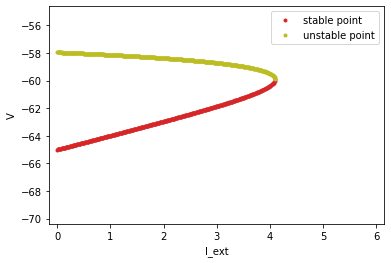

In [4]:
bif = bp.analysis.Bifurcation1D(
    model=expif,
    target_vars={'V': [-70., -55.]},
    target_pars={'I_ext': [0., 6.]},
    resolutions=0.01
)
bif.plot_bifurcation(show=True)

In the ``Bifurcation1D`` analyzer, ``model`` refers to the modelto be analyzed (essentially the analyzer will access the derivative function in the model), ``target_vars`` denotes the target variables, ``target_pars`` denotes the changing parameters, and ``resolution`` determines  the resolutioin of the analysis.

In the image above, there are two lines that "merge" together to form a bifurcation. The dots making up the lines refer to the fixed points of $\mathrm{d}V/\mathrm{d}t$. On the left of the bifurcation point (where two lines merge together), there are two fixed points where $\mathrm{d}V/\mathrm{d}t = 0$ given each external input $I_\mathrm{ext}$. One of them is a stable point, and the other is an unstable one. When $I_\mathrm{ext}$ increases, the two fixed points move closer to each other, overlap, and finally disappear.

Bifurcation analysis provides insights for the dynamics of the model, for it indicates the number and the change of stable states with respect to different parameters.

## Phase plane analysis of a 2D model

Besides bifurcationi analysis, another important tool is phase plane analysis, which displays the trajectory of the variable point in the vector field. Let's take the [FitzHugh–Nagumo (FHN) neuron model](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.neurons.FHN.html) as an example. The dynamics of the FHN model is given by:

$$
{\dot {v}}=v-{\frac {v^{3}}{3}}-w+I, \\
\tau {\dot {w}}=v+a-bw.
$$

Users can easily define a FHN model which is also provided by BrainPy:

In [5]:
fhn = bp.neurons.FHN(1)

Because there are two variables, $v$ and $w$, in the FHN model, we shall use 2-D phase plane analysis to visualize how these two variables change over time.

I am computing fx-nullcline ...
I am evaluating fx-nullcline by optimization ...
I am computing fy-nullcline ...
I am evaluating fy-nullcline by optimization ...
I am creating the vector field ...
I am searching fixed points ...
I am trying to find fixed points by optimization ...
	There are 866 candidates
I am trying to filter out duplicate fixed points ...
	Found 1 fixed points.
	#1 V=-0.2729223248464073, w=0.5338542697673022 is a unstable node.
I am plotting the trajectory ...


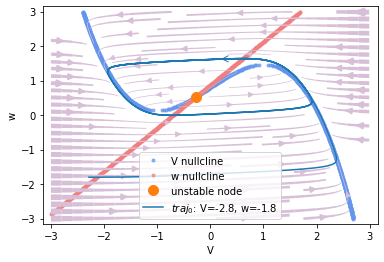

In [6]:
analyzer = bp.analysis.PhasePlane2D(
  model=fhn,
  target_vars={'V': [-3, 3], 'w': [-3., 3.]},
  pars_update={'I_ext': 0.8}, 
  resolutions=0.01,
)
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
analyzer.plot_trajectory({'V': [-2.8], 'w': [-1.8]}, duration=100.)
analyzer.show_figure()

In the ``PhasePlane2D`` analyzer, the parameters ``model``, ``target_vars``, and ``resolution`` is the same as those in ``Bifurcation1D``. ``pars_update`` specifies  the parameters to be updated during analysis. After defining the analyzer, users can visualize the nullcline, vector field, fixed points and the trajectory in the image. The phase plane gives users intuitive interpretation of the changes of $v$ and $w$ guided by the vector field (violet arrows).

## Slow point analysis of a high-dimensional system

BrainPy is also capable of performing fixed/slow point analysis of high-dimensional systems. Moreover, it can perform automatic linearization analysis around the fixed point.

In the following, we use a gap junction coupled FitzHugh–Nagumo (FHN) network as an example to demonstrate how to find fixed/slow points of a high-dimensional system.

We first define the gap junction coupled FHN network as the normal ``DynamicalSystem`` class.

In [7]:
class GJCoupledFHN(bp.dyn.DynamicalSystem):
  def __init__(self, num=4, method='exp_auto'):
    super(GJCoupledFHN, self).__init__()

    # parameters
    self.num = num
    self.a = 0.7
    self.b = 0.8
    self.tau = 12.5
    self.gjw = 0.0001

    # variables
    self.V = bm.Variable(bm.random.uniform(-2, 2, num))
    self.w = bm.Variable(bm.random.uniform(-2, 2, num))
    self.Iext = bm.Variable(bm.zeros(num))

    # functions
    self.int_V = bp.odeint(self.dV, method=method)
    self.int_w = bp.odeint(self.dw, method=method)

  def dV(self, V, t, w, Iext=0.):
    gj = (V.reshape((-1, 1)) - V).sum(axis=0) * self.gjw
    dV = V - V * V * V / 3 - w + Iext + gj
    return dV

  def dw(self, w, t, V):
    dw = (V + self.a - self.b * w) / self.tau
    return dw

  def update(self, tdi):
    t, dt = tdi.get('t'), tdi.get('dt')
    self.V.value = self.int_V(self.V, t, self.w, self.Iext, dt)
    self.w.value = self.int_w(self.w, t, self.V, dt)
    self.Iext[:] = 0.

Through simulation, we can easily find that this system has a limit cycle attractor, implying that an unstable fixed point exists.

  0%|          | 0/3000 [00:00<?, ?it/s]

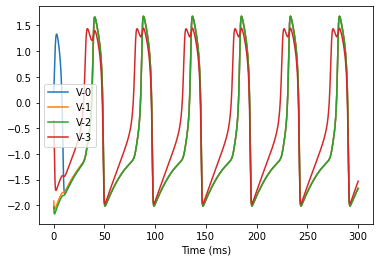

In [8]:
# initialize a network
model = GJCoupledFHN(4)
model.gjw = 0.1

# simulation with an input
Iext = bm.asarray([0., 0., 0., 0.6])
runner = bp.dyn.DSRunner(model, monitors=['V'], inputs=['Iext', Iext])
runner.run(300.)

# visualization
bp.visualize.line_plot(runner.mon.ts, runner.mon.V, legend='V',
                       plot_ids=list(range(model.num)),
                       show=True)

Let's try to optimize the fixed points for this system. Note that we only take care of the variables ``V`` and ``w``. Different from the low-dimensional analyzer, we should provide the candidate fixed points or initial fixed points when using the high-dimensional analyzer.

In [9]:
# init a slow point finder
finder = bp.analysis.SlowPointFinder(f_cell=model,
                                     target_vars={'V': model.V, 'w': model.w},
                                     inputs=[model.Iext, Iext])

# optimize to find fixed points
finder.find_fps_with_gd_method(
  candidates={'V': bm.random.normal(0., 2., (1000, model.num)),
              'w': bm.random.normal(0., 2., (1000, model.num))},
  tolerance=1e-6,
  num_batch=200,
  optimizer=bp.optim.Adam(lr=bp.optim.ExponentialDecay(0.05, 1, 0.9999)),
)

# filter fixed points whose loss is bigger than the threshold
finder.filter_loss(1e-8)

# remove the duplicate fixed points
finder.keep_unique()

Optimizing with Adam(lr=ExponentialDecay(0.05, decay_steps=1, decay_rate=0.9999), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-200 in 0.31 sec, Training loss 0.0003088239
    Batches 201-400 in 0.30 sec, Training loss 0.0002246435
    Batches 401-600 in 0.29 sec, Training loss 0.0001747461
    Batches 601-800 in 0.28 sec, Training loss 0.0001388974
    Batches 801-1000 in 0.29 sec, Training loss 0.0001120491
    Batches 1001-1200 in 0.29 sec, Training loss 0.0000913211
    Batches 1201-1400 in 0.28 sec, Training loss 0.0000750588
    Batches 1401-1600 in 0.36 sec, Training loss 0.0000621186
    Batches 1601-1800 in 0.29 sec, Training loss 0.0000517716
    Batches 1801-2000 in 0.29 sec, Training loss 0.0000434362
    Batches 2001-2200 in 0.29 sec, Training loss 0.0000366529
    Batches 2201-2400 in 0.28 sec, Training loss 0.0000311034
    Batches 2401-2600 in 0.28 sec, Training loss 0.0000265632
    Batches 2601-2800 in 0.28 sec, Training loss 0.0000228333
    

In [10]:
print('fixed points:', )
finder.fixed_points

fixed points:


{'V': array([[-1.17757852, -1.17757852, -1.17757852, -0.81465053]]),
 'w': array([[-0.59697314, -0.59697314, -0.59697314, -0.14331316]])}

In [11]:
print('fixed point losses:', )
finder.losses

fixed point losses:


array([2.77333912e-32])

Let's perform the linearization analysis of the found fixed points, and visualize its decomposition results.

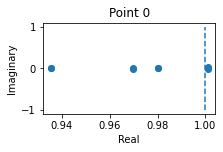

In [12]:
_ = finder.compute_jacobians(finder.fixed_points, plot=True)

This is an unstable fixed point, because one of its eigenvalues has the real part bigger than 1.

## Further reading

- For more details about how to perform bifurcation analysis and phase plane analysis, please see the tutorial of [Low-dimensional Analyzers](../tutorial_analysis/lowdim_analysis.ipynb).
- A good example of phase plane analysis and bifurcation analysis is the decision-making model, please see the tutorial in [Analysis of a Decision-making Model](../tutorial_analysis/decision_making_model.ipynb)
- If you want to how to analyze the slow points (or fixed points) of your high-dimensional dynamical models, please see the tutorial of [High-dimensional Analyzers](../tutorial_analysis/highdim_analysis.ipynb)